In [1]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from time import sleep
from lxml import html
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
from datetime import date
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# red-green color blind friendly color scheme
plt.style.use('tableau-colorblind10')

def income_statements():
    # Income statements 
    driver.get(f"https://finance.yahoo.com/quote/{ticker}/financials?p={ticker}")
    driver.implicitly_wait(3)
    #clicking "Expand All"
    btnclick = driver.find_elements(By.XPATH, "//*[@id='Col1-1-Financials-Proxy']/section/div[2]/button")
    while btnclick[0].text == 'Expand All':
        btnclick[0].click()
        driver.implicitly_wait(1.5)
    
    #parsing into lxml
    tree = html.fromstring(driver.page_source)

    #searching table financial data
    table_rows = tree.xpath("//div[contains(@class, 'D(tbr)')]") 
    # Ensure that some table rows are found
    assert len(table_rows) > 0

    parsed_rows = []

    for table_row in table_rows:
        parsed_row = []
        el = table_row.xpath("./div")

        none_count = 0

        for rs in el:
            try:
                (text,) = rs.xpath('.//span/text()[1]')
                parsed_row.append(text)
            except ValueError:
                parsed_row.append('0')
                none_count += 1

        if (none_count < 4):
            parsed_rows.append(parsed_row)
    return pd.DataFrame(parsed_rows)

def balance_sheet():
    # Balance sheet
    driver.get(f"https://finance.yahoo.com/quote/{ticker}/balance-sheet?p={ticker}")
    driver.implicitly_wait(3)
    #clicking "Expand All"
    btnclick = driver.find_elements(By.XPATH, "//*[@id='Col1-1-Financials-Proxy']/section/div[2]/button")
    while btnclick[0].text == 'Expand All':
        btnclick[0].click()
        driver.implicitly_wait(1.5)
    tree = html.fromstring(driver.page_source)

    #searching table financial data
    table_rows = tree.xpath("//div[contains(@class, 'D(tbr)')]") 
    # Ensure that some table rows are found
    assert len(table_rows) > 0

    parsed_rows = []

    for table_row in table_rows:
        parsed_row = []
        el = table_row.xpath("./div")

        none_count = 0

        for rs in el:
            try:
                (text,) = rs.xpath('.//span/text()[1]')
                parsed_row.append(text)
            except ValueError:
                parsed_row.append('0')
                none_count += 1

        if (none_count < 4):
            parsed_rows.append(parsed_row)
    return pd.DataFrame(parsed_rows)

def cash_flow():
    # Cash flow statements
    driver.get(f"https://finance.yahoo.com/quote/{ticker}/cash-flow?p={ticker}")
    driver.implicitly_wait(3)
    #clicking "Expand All"
    btnclick = driver.find_elements(By.XPATH, "//*[@id='Col1-1-Financials-Proxy']/section/div[2]/button")
    while btnclick[0].text == 'Expand All':
        btnclick[0].click()
        driver.implicitly_wait(1.5)
    tree = html.fromstring(driver.page_source)

    #searching table financial data
    table_rows = tree.xpath("//div[contains(@class, 'D(tbr)')]") 
    # Ensure that some table rows are found
    assert len(table_rows) > 0

    parsed_rows = []

    for table_row in table_rows:
        parsed_row = []
        el = table_row.xpath("./div")

        none_count = 0

        for rs in el:
            try:
                (text,) = rs.xpath('.//span/text()[1]')
                parsed_row.append(text)
            except ValueError:
                parsed_row.append('0')
                none_count += 1

        if (none_count < 4):
            parsed_rows.append(parsed_row)
    return pd.DataFrame(parsed_rows)

def currency(CUR):
    # find an exchange ratio from CUR to USD
    url2 = 'https://www.alphavantage.co/query?function=FX_MONTHLY&from_symbol={}&to_symbol=USD&apikey=G0F93DAEWJQUEWLE'.format(CUR)
    exchg = requests.get(url2)
    exdata = exchg.json()
    exrate0 = exdata["Time Series FX (Monthly)"][next(iter(exdata["Time Series FX (Monthly)"].keys()))]["1. open"]
    return float(exrate0)

def projection(F0,YEAR,rate,n):
    # projecting future cashflow for n future years
    proj_F = np.zeros(n)
    YEAR0 = YEAR.tolist().copy()
    for i in range(n):
        proj_F[i]=F0[-1]*(1+rate)**(i+1)
        YEAR0.append(YEAR[-1]+i+1)
    return YEAR0,np.hstack((F0,proj_F))

def discounted_cash_flow(FCF,wacc,pgr):
    # discount future cashflow to the present value
    m = len(FCF)
    dFCF = np.zeros(m+1)
    for i in range(m):
        dFCF[i] = FCF[i]/(1+wacc)**i
    dFCF[-1] = FCF[-1]*(1+pgr)/(wacc-pgr)

    return dFCF

In [15]:
# specify your ticker symbol, e.g., AAPL for Apple inc.
ticker = 'TICKER'
# Initialization
option = webdriver.FirefoxOptions()
option.add_argument("--headless")
driver = webdriver.Firefox(options=option)
driver.get(f"https://finance.yahoo.com/quote/{ticker}/financials?p={ticker}")
driver.implicitly_wait(3)

# Accepting cookies consent
acpclick = driver.find_elements(By.XPATH, "//*[@class='actions couple']/button")
try:
    acpclick[0].click()
except IndexError:
    pass
driver.implicitly_wait(1.5)

# Key statistics and analysts estimates
url0 = "https://apidojo-yahoo-finance-v1.p.rapidapi.com/stock/v2/get-statistics"
url1 = "https://apidojo-yahoo-finance-v1.p.rapidapi.com/stock/v2/get-analysis"
querystring = {"symbol":ticker,"region":"US"}

# you can get an api key here: https://rapidapi.com/apidojo/api/yh-finance
headers = {
    'x-rapidapi-key': "your-apidojo-api-key",
    'x-rapidapi-host': "apidojo-yahoo-finance-v1.p.rapidapi.com"
    }
stat  = requests.request("GET", url0, headers=headers, params=querystring).json()
analy = requests.request("GET", url1, headers=headers, params=querystring).json()

# Currency adjust
test=driver.find_elements(By.XPATH, "//*[@id='Col1-1-Financials-Proxy']/section/div[2]/span")[0].text
if "Currency in" in test:
    CUR = test.replace("Currency in ",'').replace(". All numbers in thousands",'')
    print(f"The financial statements are in {CUR}")
    exrate = currency(CUR)
else: exrate = 1

In [16]:
income = income_statements()
bsheet = balance_sheet()
cashf  = cash_flow()
driver.quit()

income.loc[1:,1:] = income.loc[1:,1:].replace(',','',regex=True).astype(float)
bsheet.loc[1:,1:] = bsheet.loc[1:,1:].replace(',','',regex=True).astype(float)
cashf.loc[1:,1:] = cashf.loc[1:,1:].replace(',','',regex=True).astype(float)

In [17]:
NOY   = np.shape(income)[1]-2 # Number of past years
years     = income[income[0].str.match('Breakdown')].to_numpy()[0][2:] 
years     = np.flipud(np.array([int(years[-4:]) for years in years]))
Total_Rev = np.flipud(income[income[0].str.match('Total Revenue')].loc[:,2:].to_numpy(dtype=float)[0])* exrate
Net_Inc   = np.flipud(income[income[0]=='Net Income'].loc[:,2:].to_numpy(dtype=float)[0])* exrate
Depre1    = np.flipud(income[income[0].str.contains('Reconciled Depreciation')].loc[:,2:].to_numpy(dtype=float)[0])* exrate
Depre2    = np.flipud(cashf[cashf[0].str.contains('Depreciation Amortization Depletion')].loc[:,2:].to_numpy(dtype=float)[0])* exrate
Delta_WC  = np.flipud(cashf[cashf[0].str.contains('Change in working capital')].loc[:,2:].to_numpy(dtype=float)[0])* exrate
try:
    DefTax    = np.flipud(cashf[cashf[0].str.contains('Deferred Tax')].loc[:,2:].to_numpy(dtype=float)[0])* exrate
except IndexError:
    DefTax = np.zeros_like(Delta_WC)
CFO       = np.flipud(cashf[cashf[0].str.contains('Operating Cash Flow')].loc[:,2:].to_numpy(dtype=float)[0])* exrate
try:
    SBC       = np.flipud(cashf[cashf[0].str.contains('Stock based compensation')].loc[:,2:].to_numpy(dtype=float)[0])* exrate
except IndexError:
    SBC   = np.zeros_like(CFO)
capEx     = np.flipud(cashf[cashf[0].str.contains('Capital Ex')].loc[:,2:].to_numpy(dtype=float)[0])* exrate
Sout      = np.flipud(bsheet[bsheet[0].str.contains('Share Issued')].loc[:,1:].to_numpy(dtype=float)[0][1:])*1000
try:
    TSout      = np.flipud(bsheet[bsheet[0].str.contains('Treasury Shares Number')].loc[:,1:].to_numpy(dtype=float)[0][1:])*1000
except IndexError:
    TSout      = np.zeros_like(Sout)
Sout -= TSout
# a quick fix for 'BABA ADR' since one BABA ADR stock represents 8 alibaba Hong kong stocks.
if ticker == 'BABA':
    Sout = Sout / 8
try:
    Casset    = np.flipud(bsheet[bsheet[0]=='Current Assets'].loc[:,1:].to_numpy(dtype=float)[0])* exrate
    error  = 0
except IndexError:
    Casset = np.array((1,2))
    error  = 1
try:
    Cliab     = np.flipud(bsheet[bsheet[0]=='Current Liabilities'].loc[:,1:].to_numpy(dtype=float)[0])* exrate
except IndexError:
    Cliab = np.array((1,2))
try:
    Tdebt  = np.flipud(bsheet[bsheet[0].str.contains('Total Debt')].loc[:,1:].to_numpy(dtype=float)[0])* exrate
except IndexError:
    Tdebt  = np.array((1,2))
Book      = np.flipud(bsheet[bsheet[0].str.contains('Tangible Book Value')].loc[:,1:].to_numpy(dtype=float)[0])* exrate
Tliab     = np.flipud(bsheet[bsheet[0].str.contains('Total Liabilities')].loc[:,1:].to_numpy(dtype=float)[0])* exrate
Tcash     = np.flipud(bsheet[bsheet[0].str.contains('Cash And Cash Equivalents')].loc[:,1:].to_numpy(dtype=float)[0])* exrate
Equity    = np.flipud(bsheet[bsheet[0].str.contains('Common Stock Equity')].loc[:,1:].to_numpy(dtype=float)[0])* exrate



# Sanity check 1
if cashf[cashf[0].str.contains('Capital Ex')].loc[:,2:].to_numpy(dtype=float)[0].all():
    print('DNA from income statements equals to DNA from cash flow statments')

Total_RevE = [] # Estimated Total revenue
yearsE     = [] # corresponding years
CUR_analy = analy["price"]["currency"]
if CUR_analy != 'USD':
    print(f"The estimates are in {CUR_analy}")
    analy_exrate = currency(CUR_analy)
else: analy_exrate = 1

for J in range(2):
    if analy["earningsTrend"]["trend"][J+2]["endDate"]==None:
        break
    if int(analy["earningsTrend"]["trend"][J+2]["endDate"][:4]) < int(years[-1]):
        continue
    yearsE.append(int(analy["earningsTrend"]["trend"][J+2]["endDate"][:4]))
    Total_RevE.append(int(analy["earningsTrend"]["trend"][J+2]["revenueEstimate"]["avg"]["raw"])/1000 * analy_exrate)

full_year = np.hstack((years,np.array(yearsE)))
full_Rev  = np.hstack((Total_Rev,np.array(Total_RevE)))

DNA from income statements equals to DNA from cash flow statments


In [18]:
MCAP = stat["price"]["marketCap"]["raw"]
stock_P = MCAP/Sout[-1]
if error == 1:
    current_ratio = np.nan
else:
    current_ratio = (Casset/Cliab)[-1]
debt_weight = Tdebt[-1]*1000/(Tdebt[-1]*1000+MCAP)
PE = MCAP/(Net_Inc[-1]*1000)
PS = MCAP/(Total_Rev[-1]*1000)
FPS = MCAP/(np.array(Total_RevE)[0]*1000)
RRR = 0.1
PGR  = 0.025    # perpetual growth rate
ROE  = []
ROA  = []
for i in range(NOY-1):
    ROE.append(Net_Inc[i]/np.mean(Equity[i:i+2]))
    ROA.append(Net_Inc[i]/(np.mean(Equity[i:i+2])+np.mean(Tliab[i:i+2])))
#     ROE  = Net_Inc[-1]/(np.mean(Equity[-2:]))
#     ROA  = Net_Inc[-1]/(np.mean(Equity[-2:])+np.mean(Tliab[-2:]))
DE   = Tliab[-1]/Equity[-1]

print("Stock price: {:.2f} USD".format(stock_P))
print("Market Cap: {:.2f}B USD".format(MCAP/1000000000))
print("Total debt: {:.2f}B USD".format(Tdebt[-1]/1000000))
print("Weight of debt: {:.2f}%".format(debt_weight*100))
print("Current ratio: {:.2f}".format(current_ratio))
print("Debt to equity: {:.2f}".format(DE))
print("Return on equity: {:.2f}%".format(ROE[-1]*100))
print("Return on asset: {:.2f}%".format(ROA[-1]*100))
print("Trailing PE ratio: {:.2f}".format(PE))
print("Trailing PS ratio: {:.2f}".format(PS))
print("1 year forward PS ratio: {:.2f}".format(FPS))
print("Required rate of return: {:.2f}%".format(RRR*100))
print("Perpetual growth rate {:.1f}%".format(PGR*100))

Stock price: 64.12 USD
Market Cap: 49.57B USD
Total debt: 7.46B USD
Weight of debt: 13.09%
Current ratio: 2.73
Debt to equity: 1.24
Return on equity: 20.43%
Return on asset: 8.94%
Trailing PE ratio: 14.59
Trailing PS ratio: 4.53
1 year forward PS ratio: 4.60
Required rate of return: 10.00%
Perpetual growth rate 2.5%


In [19]:
FCF = Net_Inc + Depre1 + Delta_WC + DefTax + capEx
FCF0 = CFO - SBC + capEx
print(FCF)
FTR = FCF/Total_Rev  # Free cash flow to total revenue ratio
length = np.shape(FTR)[0]
print(np.round(FTR,3))
W1=np.geomspace(1,2,length)
W1norm = np.sum(W1)
weight = W1/W1norm
avgFTR = np.average(FTR,weights=weight)  # average ratio excluding negative values
stdFTR = np.sqrt(np.cov(FTR, aweights=weight))   # STD of the ratio excluding negative values
# estFTR = avgFTR-stdFTR
print(f"Avg={avgFTR:.3}, Std={stdFTR:.3}, Avg-Std={avgFTR-stdFTR:.3}")

[1068100. 1174700. 2174000. 3375200.]
[0.151 0.161 0.272 0.309]
Avg=0.24, Std=0.0792, Avg-Std=0.161


In [20]:
estFTR=0.2

In [21]:
GR = full_Rev[1:]/full_Rev[:-1] -1 
GRlength = np.shape(GR)[0]
GRW1=np.geomspace(1,2,GRlength)
GRW1norm = np.sum(GRW1)
GRweight = GRW1/GRW1norm
avgGR = np.average(GR,weights=GRweight)
stdGR = np.sqrt(np.cov(GR,aweights=GRweight))
print(np.round(GR,3))
print(f"Avg={avgGR:.3}, Std={stdGR:.3}, Avg-Std={avgGR-stdGR:.3}")

[ 0.027  0.096  0.369 -0.015  0.081]
Avg=0.11, Std=0.151, Avg-Std=-0.0408


In [22]:
estGR = 0.1

In [23]:
YEAR0, proj_TR = projection(full_Rev,full_year,estGR,2)
index = YEAR0.index(years[-1])
proj_FCF = proj_TR[index+1:] * estFTR
disc_FCF = discounted_cash_flow(proj_FCF,RRR,PGR)
int_Value = np.sum(disc_FCF)
FVoE     = int_Value*1000/Sout[-1]
MOS       = 0.5
IEP       = FVoE * (1-MOS)
PF       = MCAP/(FCF[-1]*1000)
FPF       = MCAP/(proj_FCF[0]*1000)
PB        = MCAP/(Book[-1]*1000)
BperS     = Book[-1]*1000/Sout[-1]
CperS     = Tcash[-1]*1000/Sout[-1]

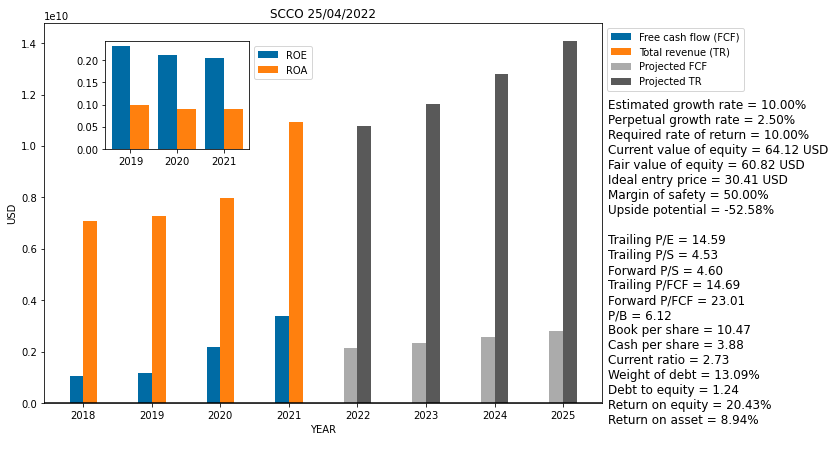

In [24]:
anno_str = 'Estimated growth rate = {:0.2f}%'.format(estGR*100)+'\n'
anno_str += 'Perpetual growth rate = {:0.2f}%'.format(PGR*100)+'\n'
anno_str += 'Required rate of return = {:0.2f}%'.format(RRR*100)+'\n'
anno_str += 'Current value of equity = {:.2f} USD'.format(stock_P)+'\n'
anno_str += 'Fair value of equity = {:.2f} USD'.format(FVoE)+'\n'
anno_str += 'Ideal entry price = {:.2f} USD'.format(IEP)+'\n'
anno_str += 'Margin of safety = {:.2f}%'.format(MOS*100)+'\n'
anno_str += 'Upside potential = {:.2f}%'.format((IEP/stock_P-1)*100)+'\n'
anno_str += '\n'
anno_str += 'Trailing P/E = {:0.2f}'.format(PE)+'\n'
anno_str += 'Trailing P/S = {:0.2f}'.format(PS)+'\n'
anno_str += 'Forward P/S = {:0.2f}'.format(FPS)+'\n'
anno_str += 'Trailing P/FCF = {:0.2f}'.format(PF)+'\n'
anno_str += 'Forward P/FCF = {:0.2f}'.format(FPF)+'\n'
anno_str += 'P/B = {:0.2f}'.format(PB)+'\n'
anno_str += 'Book per share = {:0.2f}'.format(BperS)+'\n'
anno_str += 'Cash per share = {:0.2f}'.format(CperS)+'\n'
anno_str += 'Current ratio = {:.2f}'.format(current_ratio)+'\n'
anno_str += 'Weight of debt = {:.2f}%'.format(debt_weight*100)+'\n'
anno_str += 'Debt to equity = {:.2f}'.format(DE)+'\n'
anno_str += 'Return on equity = {:.2f}%'.format(ROE[-1]*100)+'\n'
anno_str += 'Return on asset = {:.2f}%'.format(ROA[-1]*100)+'\n'



today = date.today()
d1 = today.strftime("%d/%m/%Y")

n0  = len(FCF)
n1  = len(full_year)
n2  = len(YEAR0)

N   = np.linspace(0,n0-1,n0)
NN  = np.linspace(N[-1]+1,N[-1]+2+(n1-n0),2+(n1-n0))
fig = plt.figure(figsize=(10,7))
ax = fig.gca()
ax.bar(N-0.1,FCF*1000,width=0.2, label = 'Free cash flow (FCF)')
ax.axhline(0,color='k')
# ax.bar(N,NI,width=0.2, label = 'Net income')
ax.bar(N+0.1,full_Rev[:index+1]*1000,width=0.2, label = 'Total revenue (TR)')
ax.bar(NN-0.1,proj_FCF*1000,width=0.2, label = 'Projected FCF')
# ax.bar(proj_N[:-1],proj_FCF[:-1],width=0.2, label = 'Discounted FCF')
ax.bar(NN+0.1,proj_TR[index+1:]*1000,width=0.2, label='Projected TR')
ax.set_xticks(np.hstack((N,NN)))
ax.set_xticklabels(YEAR0)
ax.set_ylabel("USD")
ax.set_xlabel("YEAR")
ax.set_title(ticker+' '+d1)
ax.annotate(anno_str,
            xy = (1.01,0.8), xycoords='axes fraction', ha='left',va='top' ,fontsize =12)
# ax.annotate(anno_str2,
#             xy = (0.02,0.98), xycoords='axes fraction', ha='left',va='top',fontsize =12)
ax.legend(loc='upper left',ncol=1,bbox_to_anchor=(1.,1))

axins = inset_axes(ax, width=2, height=1.5, bbox_to_anchor=(300,430))
axins.bar(years[1:]-0.2,ROE,width=0.4,label = "ROE")
axins.bar(years[1:]+0.2,ROA,width=0.4,label = "ROA")
axins.legend(loc='upper left',ncol=1,bbox_to_anchor=(1.,1))


plt.savefig(ticker+'.pdf',bbox_inches='tight')
plt.show()